In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1.1 Check the column names ---

# Define the path to your CSV file
csv_file_path = '../data/jobs.csv'

# Attempt to read the CSV file to get column names
try:
    # Load the CSV file with pandas to retrieve column names
    dummy_df = pd.read_csv(csv_file_path, nrows=0)  # Read only the header row for efficiency
    column_names = list(dummy_df.columns)  # Extract column names from the header row
    print("Column names:", column_names)
except FileNotFoundError:
    print(f"Error: The file {csv_file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please check the file path and format.")

Column names: ['jobTitle', 'companyName', 'lid', 'jobDescRaw', 'finalZipcode', 'finalState', 'finalCity', 'companyBranchName', 'jobDescUrl', 'nlpBenefits', 'nlpSkills', 'nlpSoftSkills', 'nlpDegreeLevel', 'nlpEmployment', 'nlpSeniority', 'correctDate', 'scrapedLocation']


Unknown columns: 'lid', NLP related columns: 'nlpBenefits', 'nlpSkills', 'nlpSoftSkills', 'nlpDegreeLevel', 'nlpEmployment', 'nlpSeniority'

In [2]:
# --- 1.2 Loading the Data ---

print(f"Attempting to load data from: {csv_file_path}")
try:
    # Load the CSV file into a pandas DataFrame
    # We can add on_bad_lines='skip' or low_memory=False if we encounter parsing issues
    # Specify column names if the CSV doesn't have a header row or if you want to enforce names
    # If the CSV *does* have a header, you might remove the `names=column_names` and `header=0` (default)
    df = pd.read_csv(csv_file_path) # Adjust parameters if needed based on file structure

    print("Data loaded successfully.")
    print(f"Shape of the DataFrame: {df.shape}")

except FileNotFoundError:
    print(f"Error: The file {csv_file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please check the file path, format, and column names.")

Attempting to load data from: ../data/jobs.csv
Data loaded successfully.
Shape of the DataFrame: (100000, 17)


In [3]:
# --- 2. Data Exploration (EDA) ---

print("\n--- Initial Data Overview ---")
# Display the first row of the DataFrame with transposed layout for better readability
print("\nFirst row:")
print(df.head(1).T)



--- Initial Data Overview ---

First row:
                                                                   0
jobTitle                 Nuclear Medicine Tech, Full Time, Day Shift
companyName                                         Adventist Health
lid                                 07213bcc5db0efec311b1884459defed
jobDescRaw         <div class="normalText"><p>Job Description</p>...
finalZipcode                                                   93465
finalState                                                       CA,
finalCity                                                  Templeton
companyBranchName           Adventist Health || Templeton, CA, 93465
jobDescUrl         https://www.postjobfree.com/job/vubjwa/nuclear...
nlpBenefits                                                       []
nlpSkills          ['Nuclear Medicine', 'Wound Care', 'Digestive ...
nlpSoftSkills                                  ['Computer Literacy']
nlpDegreeLevel                                        ['Asso

'lid' looks like an identifier or index  
'jobDescRaw' is in HTML format, which needs parsing  
nlp prefix seems not relavant. Should just treat those columns as they suggest

In [4]:
# Display basic information (data types, non-null counts)
print("\nDataFrame Info:")
df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   jobTitle           100000 non-null  object
 1   companyName        99675 non-null   object
 2   lid                100000 non-null  object
 3   jobDescRaw         100000 non-null  object
 4   finalZipcode       97949 non-null   object
 5   finalState         98580 non-null   object
 6   finalCity          98205 non-null   object
 7   companyBranchName  99675 non-null   object
 8   jobDescUrl         100000 non-null  object
 9   nlpBenefits        100000 non-null  object
 10  nlpSkills          100000 non-null  object
 11  nlpSoftSkills      100000 non-null  object
 12  nlpDegreeLevel     100000 non-null  object
 13  nlpEmployment      100000 non-null  object
 14  nlpSeniority       100000 non-null  object
 15  correctDate        99986 non-null   object
 16  scra

In [5]:
# Identify all columns with null values and add them to a list
# We need to take care of them later, good thing is that they are not many
null_columns = [col for col in df.columns if df[col].isnull().any()]

# Print the columns with null values
print("\nColumns with null values:")
print(null_columns)


Columns with null values:
['companyName', 'finalZipcode', 'finalState', 'finalCity', 'companyBranchName', 'correctDate']


In [6]:
# Display summary statistics for categorical/object columns
print("\nSummary Statistics (Categorical/Object):")
summary_df = df.describe(include='object')

for i in range(0, len(summary_df.columns), 3):
    print(summary_df.iloc[:, i:i+3])


Summary Statistics (Categorical/Object):
               jobTitle companyName                               lid
count            100000       99675                            100000
unique            51692       25503                            100000
top     Delivery Driver    DoorDash  07213bcc5db0efec311b1884459defed
freq                736        4438                                 1
                                               jobDescRaw finalZipcode  \
count                                              100000        97949   
unique                                              90535        17617   
top     <div class="show-more-less-html__markup show-m...       remote   
freq                                                  134          635   

       finalState  
count       98580  
unique        247  
top            CA  
freq         5188  
       finalCity                        companyBranchName  \
count      98205                                    99675   
unique      707

All lid values are unique confirming our previous guess that it is a  an identifier  
Most common job title is Delivery Driver and the most common company is Doordash. It means that this dataset contains jobs other than tech  
For jobDescRaw, there are duplicates! We can use they as a probe in later stages to see if our embedding model is working well  
In finalZipcode, there are "remote" which means we could create a new column to indicate if the job is remote or not  
Barcadia Bar & Grill || New Orleans, LA is the most common company branch name! Should give it a try when go to New Orleans  
For jobDescUrl, its all unique, we can decompse the url into different parts and see if we can get more information (ignoring https, www, etc)

In [7]:
print("\n--- Missing Value Analysis ---")
# Check for missing values per column
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Count': missing_values, 'Percentage': missing_percent})
print("\nMissing Values per Column:")
print(missing_df[missing_df['Count'] > 0].sort_values(by='Percentage', ascending=False))


--- Missing Value Analysis ---

Missing Values per Column:
                   Count  Percentage
finalZipcode        2051       2.051
finalCity           1795       1.795
finalState          1420       1.420
companyName          325       0.325
companyBranchName    325       0.325
correctDate           14       0.014


Missing rate is tolerable. We should consider mending them via fillinging with a placeholder/common values or drop

In [8]:
print("\n--- Duplicate Row Check ---")
# Check for exact duplicate rows based on all columns
print(f"\nNumber of exact duplicate rows: {df.duplicated().sum()}")
# Check for duplicates based on key identifiers (e.g., title, company, description start)
# Note: Exact jobDescRaw duplicates might be rare. Consider a subset if checking description.
key_cols = ['jobTitle', 'companyName', "finalZipcode", "correctDate"] # Add more columns if needed
print(f"Number of duplicate rows based on {key_cols}: {df.duplicated(subset=key_cols).sum()}")


--- Duplicate Row Check ---

Number of exact duplicate rows: 0
Number of duplicate rows based on ['jobTitle', 'companyName', 'finalZipcode', 'correctDate']: 4726


We should consider dropping duplicate rows. They do not take up that big ratio

In [9]:
print("\n--- Value Counts for Key Columns ---")
# Analyze distributions of important categorical features

# Top 20 Companies
print("\nTop 20 Company Names:")
print(df['companyName'].value_counts().head(20))

# Top 20 Job Titles
print("\nTop 20 Job Titles:")
print(df['jobTitle'].value_counts().head(20))

# State distribution
print("\nJob Postings per State (Top 10):")
print(df['finalState'].value_counts().head(10))

# Seniority Level
print("\nJob Postings per Seniority Level:")
print(df['nlpSeniority'].value_counts())

# Employment Type
print("\nJob Postings per Employment Type:")
print(df['nlpEmployment'].value_counts())


--- Value Counts for Key Columns ---

Top 20 Company Names:
companyName
DoorDash                           4438
CompHealth                         3795
TravelNurseSource                  2279
LocumJobsOnline                    1539
Thriveworks                        1535
Chico's                            1007
RemoteWorker CA                     858
The GIANT Company                   750
AlliedTravelCareers                 619
Class A Drivers                     486
Jobot                               457
The Job Network                     454
HealthTrust Workforce Solutions     414
Domino's Franchise                  411
Insomnia Cookies                    403
Intermountain Health                382
Supplemental Health Care            337
Lone Star College                   302
Mass General Brigham                299
AHS Staffing                        296
Name: count, dtype: int64

Top 20 Job Titles:
jobTitle
Delivery Driver                                           736
Delivery D

Job Desdescription is probably the most important for our task. We should analyze it more


--- Job Description Analysis ---

Job Description Length Statistics:
count    100000.000000
mean       3894.747850
std        2321.626015
min           9.000000
25%        2288.000000
50%        3350.000000
75%        5140.000000
max       35528.000000
Name: jobDescLength, dtype: float64


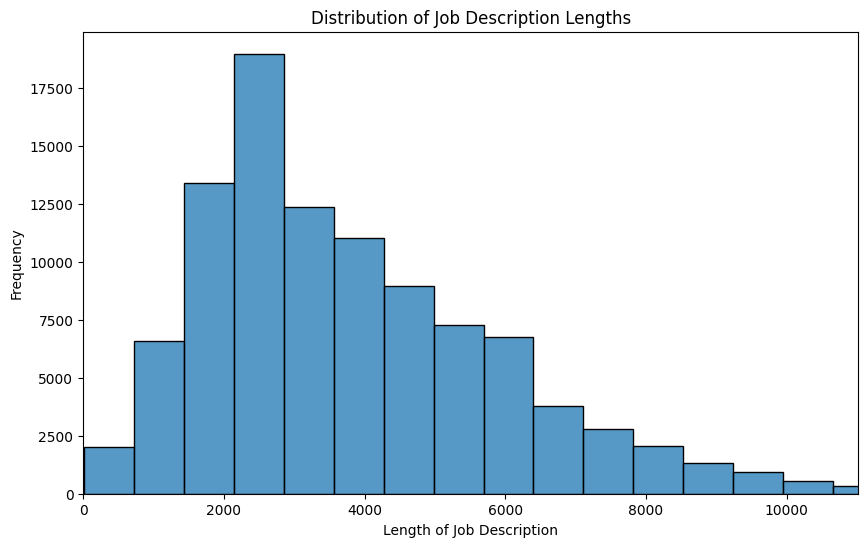


Number of job descriptions with length < 50 characters: 9


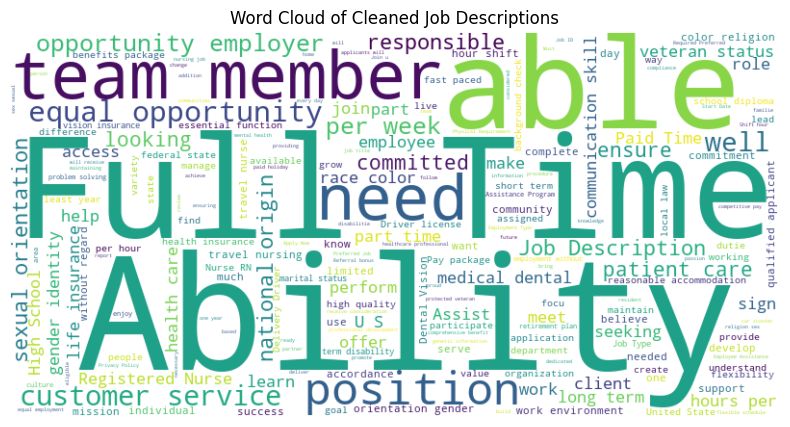

In [10]:
print("\n--- Job Description Analysis ---")
# Analyze the length of job descriptions
# Ensure 'jobDescRaw' is string type, fill NaNs with empty string
df['jobDescRaw'] = df['jobDescRaw'].astype(str).fillna('')
df['jobDescLength'] = df['jobDescRaw'].apply(len)

print("\nJob Description Length Statistics:")
print(df['jobDescLength'].describe())

# Plot histogram of job description lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['jobDescLength'], bins=50, kde=False)
plt.title('Distribution of Job Description Lengths')
plt.xlabel('Length of Job Description')
plt.ylabel('Frequency')
plt.xlim(0, df['jobDescLength'].quantile(0.99))
plt.show()

# Check for very short descriptions
print(f"\nNumber of job descriptions with length < 50 characters: {len(df[df['jobDescLength'] < 50])}")

# Import necessary libraries for HTML cleaning
from bs4 import BeautifulSoup
from wordcloud import WordCloud

# Extract text content from 'jobDescRaw' and create a new column 'jobDescClean'
df['jobDescClean'] = df['jobDescRaw'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(separator=" "))

# Create a word cloud from 'jobDescClean' column
text_clean = ' '.join(df['jobDescClean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_clean)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Job Descriptions')
plt.show()


### EDA Summary: Key Findings and Observations

Based on previous EDA steps, here are the key findings and observations:

1.  **Dataset Overview:** The dataset contains 100,000 job postings with 17 columns. Key columns like `jobTitle`, `companyName`, and `jobDescRaw` are present.
2.  **Unique Identifier:** The `lid` column consists of unique values and serves as a reliable identifier for each job posting.
3.  **Job Descriptions:**
    * The `jobDescRaw` column contains HTML content.
    * Description lengths vary significantly (min 9, max ~35k chars), but most are substantial (mean ~3.9k chars). Very few (<10) are shorter than 50 characters.
4.  **Missing Data:** Missing values exist in `companyName`, `finalZipcode`, `finalState`, `finalCity`, `companyBranchName`, and `correctDate`. However, the percentage of missing data is low for all affected columns (max 2.05% for `finalZipcode`).
5.  **Duplicates:**
    * There are no exact duplicate rows across all columns.
    * However, 4,726 rows are duplicates based on the combination of `jobTitle`, `companyName`, `finalZipcode`, and `correctDate`.
    * Some exact duplicates were found in the raw HTML of `jobDescRaw` itself.
6.  **Categorical Data Insights:**
    * The dataset includes a variety of job types, with "Delivery Driver" being the most frequent title and "DoorDash" the most frequent company.
    * Location data (`finalState`, `finalCity`, `finalZipcode`) shows some inconsistencies: `finalZipcode` contains the value "remote", and `finalState` has variations like "CA" and "CA,".
7.  **NLP Columns:** Several columns (`nlpBenefits`, `nlpSkills`, etc.) seem to contain lists or structured data, often empty (`[]`). Their direct utility might be limited if focusing on `jobDescRaw` embeddings.

### Data Preprocessing Summary

**Preprocessing Already Done (in the above code):**


* Job description length calculated (`jobDescLength`).
* **HTML content extracted from `jobDescRaw` into a new `jobDescClean` column using BeautifulSoup**.

**Proposed Next Preprocessing Steps:**

1.  **Handle Missing Values:** Address the NaNs in columns like `companyName`, `finalZipcode`, `finalState`, `finalCity`, `companyBranchName`, and `correctDate`. Given the low percentage, strategies could include filling with a placeholder ('Unknown') or dropping the rows. **We chose to fill with placeholder because it aligns better with real world use cases where missing values are kind of unavoidable.**
2.  **Remove Duplicates:** Drop the 4,726 duplicate rows identified based on `['jobTitle', 'companyName', 'finalZipcode', 'correctDate']` to avoid redundant entries.
3.  **Clean Location Data:**
    * Standardize `finalState` (e.g., remove trailing commas).
    * Address the "remote" value in `finalZipcode` (**if we later on build a non-embedding model to help with our prediction we could replace with NaN or a standard code like '00000' for format consistency but since we use text embedding model, we can leave it as is now**).
    * Consider standardizing `finalCity` (e.g., title case).
4.  \***Convert Date:** Convert the `correctDate` column to datetime objects for potential time-based analysis or filtering (**We did not do this preprocessing because we are using text embedding model**).
5.  **Clean Text Data:** Apply basic text cleaning to `jobDescClean` (e.g., lowercasing, removing extra whitespace) to prepare it for embedding.
6.  **Drop Unused Columns:** Remove columns not needed for embedding or analysis (e.g., `jobDescRaw` now that `jobDescClean` exists, potentially the `nlp*` columns, `jobDescUrl`, `companyBranchName`, `scrapedLocation` unless needed for context). **Note that we could conduct feature enhancement with `nlp*` columns but we will leave it for now. jobDescUrl can be used for other ML model but probably not for text embedding model.**

In [11]:
import pandas as pd
from bs4 import BeautifulSoup
import re

# Make a copy to avoid modifying the original DataFrame directly
df_processed = df.copy()

print(f"Original DataFrame shape: {df_processed.shape}")

# --- 1. Handle Missing Values ---
print("\n--- Handling Missing Values ---")

# Strategy: Fill categorical/location NaNs with 'Unknown'
fill_unknown_cols = ['companyName', 'finalZipcode', 'finalState', 'finalCity', 'companyBranchName']
for col in fill_unknown_cols:
    # Check if column exists before filling
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna('Unknown')
        print(f"Filled NaN in '{col}' with 'Unknown'.")

# Drop rows where 'correctDate' is missing (only 14 according to EDA)
if 'correctDate' in df_processed.columns:
    initial_rows = df_processed.shape[0]
    df_processed.dropna(subset=['correctDate'], inplace=True)
    rows_dropped = initial_rows - df_processed.shape[0]
    print(f"Dropped {rows_dropped} rows with missing 'correctDate'.")

# Verify no more missing values in these columns
print("\nMissing values after handling:")
print(df_processed[['companyName', 'finalZipcode', 'finalState', 'finalCity', 'companyBranchName', 'correctDate']].isnull().sum())

Original DataFrame shape: (100000, 19)

--- Handling Missing Values ---
Filled NaN in 'companyName' with 'Unknown'.
Filled NaN in 'finalZipcode' with 'Unknown'.
Filled NaN in 'finalState' with 'Unknown'.
Filled NaN in 'finalCity' with 'Unknown'.
Filled NaN in 'companyBranchName' with 'Unknown'.
Dropped 14 rows with missing 'correctDate'.

Missing values after handling:
companyName          0
finalZipcode         0
finalState           0
finalCity            0
companyBranchName    0
correctDate          0
dtype: int64


In [12]:
# --- 2. Remove Duplicates ---
print("\n--- Removing Duplicates ---")
# Remove duplicates based on the key columns identified in EDA
# key_cols = ['jobTitle', 'companyName', 'finalZipcode', 'correctDate'] # our old version, however, I realize there could be same role same day from same company but has different seniority. Use jobDescClean instead. [cite: 38]
key_cols = ['jobDescClean'] # this column has been added in previous step.
if all(col in df_processed.columns for col in key_cols):
    initial_rows = df_processed.shape[0]
    df_processed.drop_duplicates(subset=key_cols, keep='first', inplace=True)
    rows_dropped = initial_rows - df_processed.shape[0]
    print(f"Dropped {rows_dropped} duplicate rows based on {key_cols}.")
else:
    print(f"Skipping duplicate removal based on {key_cols} as one or more columns are missing.")


--- Removing Duplicates ---
Dropped 9635 duplicate rows based on ['jobDescClean'].


In [13]:

# --- 3. Clean Location Data ---
print("\n--- Cleaning Location Data ---")

# Standardize 'finalState' (remove trailing commas and whitespace)
if 'finalState' in df_processed.columns:
    df_processed['finalState'] = df_processed['finalState'].astype(str).str.replace(r'\s*,\s*$', '', regex=True).str.strip()
    print("Cleaned 'finalState' (removed trailing commas/whitespace).")
    print("Example 'finalState' values after cleaning:")
    print(df_processed['finalState'].value_counts().head())

# Handle 'remote' in 'finalZipcode' - replace with 'REMOTE'
if 'finalZipcode' in df_processed.columns:
    df_processed['finalZipcode'] = df_processed['finalZipcode'].astype(str).str.replace('remote', 'REMOTE', case=False)
    print("Cleaned 'finalZipcode' (replaced 'remote' with 'REMOTE').")

# Standardize 'finalCity' (convert to title case)
if 'finalCity' in df_processed.columns:
    df_processed['finalCity'] = df_processed['finalCity'].astype(str).str.title().str.strip()
    print("Cleaned 'finalCity' (converted to title case).")


--- Cleaning Location Data ---
Cleaned 'finalState' (removed trailing commas/whitespace).
Example 'finalState' values after cleaning:
finalState
CA    7571
TX    6257
FL    4865
PA    4489
NY    4225
Name: count, dtype: int64
Cleaned 'finalZipcode' (replaced 'remote' with 'REMOTE').
Cleaned 'finalCity' (converted to title case).


In [14]:
# --- *. Convert Date ---
# print("\n--- Converting Date Column ---")
# if 'correctDate' in df_processed.columns:
#     # Attempt conversion, coercing errors to NaT (Not a Time)
#     df_processed['correctDate'] = pd.to_datetime(df_processed['correctDate'], errors='coerce')
#     # Check if any dates failed to parse
#     failed_parses = df_processed['correctDate'].isnull().sum()
#     if failed_parses > 0:
#         print(f"Warning: {failed_parses} entries in 'correctDate' could not be parsed and were set to NaT.")
#     else:
#         print("Converted 'correctDate' to datetime objects.")


# --- 4. Clean Text Data (jobDescClean) ---
print("\n--- Cleaning Job Description Text ---")
# Ensure 'jobDescClean' column exists (created in EDA step)
if 'jobDescClean' not in df_processed.columns:
     # Re-create 'jobDescClean' if it wasn't carried over
     print("Re-creating 'jobDescClean' from 'jobDescRaw'...")
     if 'jobDescRaw' in df_processed.columns:
         df_processed['jobDescRaw'] = df_processed['jobDescRaw'].astype(str).fillna('')
         df_processed['jobDescClean'] = df_processed['jobDescRaw'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(separator=" "))
     else:
         print("Error: Cannot create 'jobDescClean' as 'jobDescRaw' is missing.")

# Perform cleaning only if 'jobDescClean' exists
if 'jobDescClean' in df_processed.columns:
    # Convert to lowercase
    df_processed['jobDescClean'] = df_processed['jobDescClean'].str.lower()
    # Remove extra whitespace (leading/trailing/multiple spaces)
    df_processed['jobDescClean'] = df_processed['jobDescClean'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    # Optional: Remove punctuation, numbers, etc. depending on embedding model requirements
    # df_processed['jobDescClean'] = df_processed['jobDescClean'].str.replace(r'[^\w\s]', '', regex=True)
    print("Cleaned 'jobDescClean' (lowercase, extra whitespace removed).")


--- Cleaning Job Description Text ---
Cleaned 'jobDescClean' (lowercase, extra whitespace removed).


In [15]:
# --- 5. Drop Unused Columns ---
print("\n--- Dropping Unused Columns ---")
columns_to_drop = [
    'jobDescRaw', # Original HTML description, replaced by jobDescClean
    'jobDescLength', # Was intermediate calculation
    'jobDescUrl', 'companyBranchName', 'scrapedLocation', # Likely not needed for core task
    # Potentially drop NLP columns if not used:
    'nlpBenefits', 'nlpSkills', 'nlpSoftSkills', 'nlpDegreeLevel',
    'nlpEmployment', 'nlpSeniority'
]
# Drop only columns that actually exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df_processed.columns]
if existing_columns_to_drop:
    df_processed.drop(columns=existing_columns_to_drop, inplace=True)
    print(f"Dropped columns: {existing_columns_to_drop}")
else:
    print("No columns specified for dropping were found.")


--- Dropping Unused Columns ---
Dropped columns: ['jobDescRaw', 'jobDescLength', 'jobDescUrl', 'companyBranchName', 'scrapedLocation', 'nlpBenefits', 'nlpSkills', 'nlpSoftSkills', 'nlpDegreeLevel', 'nlpEmployment', 'nlpSeniority']


In [16]:
# --- Final Check ---
print("\n--- Preprocessing Complete ---")
print(f"Processed DataFrame shape: {df_processed.shape}")
print("\nFinal DataFrame Info:")
df_processed.info()
print("\nFirst row of processed data:")
print(df_processed.head(1).T)

# Save the processed data
output_csv_path = '../data/jobs_processed.csv'
df_processed.to_csv(output_csv_path, index=False)
print(f"\nProcessed data saved to {output_csv_path}")


--- Preprocessing Complete ---
Processed DataFrame shape: (90351, 8)

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 90351 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   jobTitle      90351 non-null  object
 1   companyName   90351 non-null  object
 2   lid           90351 non-null  object
 3   finalZipcode  90351 non-null  object
 4   finalState    90351 non-null  object
 5   finalCity     90351 non-null  object
 6   correctDate   90351 non-null  object
 7   jobDescClean  90351 non-null  object
dtypes: object(8)
memory usage: 6.2+ MB

First row of processed data:
                                                              0
jobTitle            Nuclear Medicine Tech, Full Time, Day Shift
companyName                                    Adventist Health
lid                            07213bcc5db0efec311b1884459defed
finalZipcode                                              